# Impact of changing damage function location on forecast value

In [13]:
# Copyright 2024 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [14]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('..')
from ruv.relative_utility_value import relative_utility_value
from ruv.damage_functions import logistic, user_defined
from ruv.economic_models import cost_loss, cost_loss_analytical_spend
from ruv.utility_functions import cara
from ruv.decision_rules import optimise_over_forecast_distribution
from ruv.helpers import risk_aversion_coef_to_risk_premium, risk_premium_to_risk_aversion_coef

# Load example forecast dataset

In [15]:
# Steamflow at Taggerty in the Golburn catchment of the southern Murray-Darling basin
# Subseasonal streamflow forecasts from MuTHRE

# load forecasts (and obs) and climatology
data = pd.read_csv('example_data/405209-muthre.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')
clim = pd.read_csv('example_data/405209-climatology.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')

# convert runoff to cumecs
data *= 629.4 / 86.4
clim *= 629.4 / 86.4

# filter to the first week of each month
data = data[(data.index.day >= 1) & (data.index.day <= 7)]
clim = clim[(clim.index.day >= 1) & (clim.index.day <= 7)]

# fetch the obs and forecast ensemble
obs = data['obs']
fcst = data[[col for col in data.columns if col.startswith('ens-')]]
clim = clim[[col for col in clim.columns if col.startswith('ens-')]]

# clean climatology of NA ensemble members from ragged 14-day moving average climatology dataset
clim_arr = clim.to_numpy()
sorted_arr = np.take_along_axis(clim_arr, np.argsort(np.isnan(clim_arr), axis=1, kind='stable'), axis=1)
max_size_ens = np.count_nonzero(~np.isnan(clim_arr), axis=1).min()
ens = sorted_arr[:, :max_size_ens]
clim = pd.DataFrame(ens, index=clim.index, columns=[f"ens-{i+1}" for i in range(max_size_ens)])

# RUV library expects numpy arrays
obs = obs.values
fcst = fcst.values
clim = clim.values

print(obs.shape, fcst.shape, clim.shape)

(1932,) (1932, 100) (1932, 508)


# Experiment setup

In [16]:
parallel_nodes = 4

# define range of alphas we will calculate over
alpha_step = 0.05
alphas = np.arange(alpha_step, 1, alpha_step)

# calculate adjust the risk aversion coefficient according to the max damages
target_unity_risk_aversion = 0.15
max_damages = 10000
target_risk_premium = risk_aversion_coef_to_risk_premium(target_unity_risk_aversion, 1)
adjusted_risk_aversion = risk_premium_to_risk_aversion_coef(target_risk_premium, max_damages)

# Define different damage functions
damage_functions = {}

flow_damage_pairs = [
    (0, max_damages),
    (np.nanquantile(obs, 0.1), 0),      # bottom 10% of flow
    (np.nanquantile(obs, 0.95), 0),     # top 5% of flow
    (np.nanquantile(obs, 0.998), max_damages)
]
damage_functions['low and high'] = [user_defined, {'points': flow_damage_pairs}]

flow_damage_pairs = [
    (0, 0),
    (np.nanquantile(obs, 0.1), 0),
    (np.nanquantile(obs, 0.95), 0),
    (np.nanquantile(obs, 0.998), max_damages)
]
damage_functions['only high'] = [user_defined, {'points': flow_damage_pairs}]

flow_damage_pairs = [
    (0, max_damages),
    (np.nanquantile(obs, 0.1), 0),
    (np.nanquantile(obs, 0.95), 0),
    (np.nanquantile(obs, 0.998), 0)
]
damage_functions['only low'] = [user_defined, {'points': flow_damage_pairs}]

damage_functions['only high (logistic)'] = [logistic, {'k': 0.2, 'A': max_damages, 'threshold': np.nanquantile(obs, 0.991)}]

# use 14-day moving average climatology as reference
ref = clim

C:\Users\me\work\research\software\relative-utility-value\ruv\helpers.py:64: RuntimeWarning: overflow encountered in exp
  return np.log(0.5 * (np.exp(-A * gamble_size) + np.exp(A * gamble_size))) / (A * gamble_size) - risk_premium


# Damage functions figure

In [17]:
streamflow = np.arange(0, np.nanmax(obs) * 1.3, 0.01)
streamflow_damages = pd.DataFrame(index=streamflow, columns=list(damage_functions.keys()))
for name, damage_function in damage_functions.items():
    damage_fnc_mth = damage_function[0]
    damage_fnc_params = damage_function[1]
    damage_fnc = damage_fnc_mth(damage_fnc_params)
    streamflow_damages[name] = damage_fnc(streamflow)

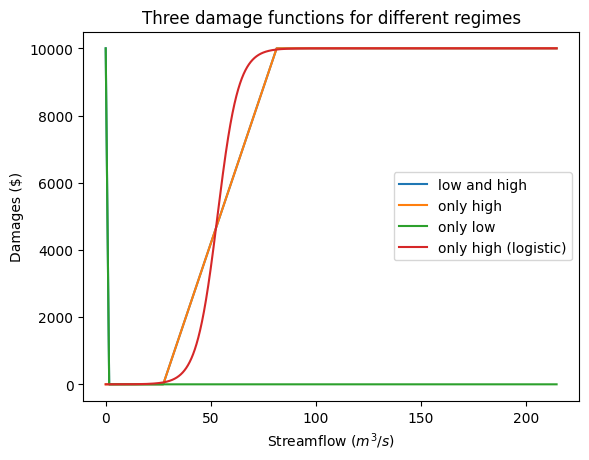

In [18]:
for name, damage_function in damage_functions.items():
    streamflow_damages[name].plot(label=name)
plt.title('Three damage functions for different regimes')
plt.xlabel(r'Streamflow ($m^3/s$)')
plt.ylabel('Damages ($)')
plt.legend()

# Value diagram for three damage functions

## Define decision context

In [19]:
decision_context = {
    'utility_function': [cara, {'A': adjusted_risk_aversion}],
    'decision_rule': [optimise_over_forecast_distribution, None],
    'decision_thresholds': None,
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'damage_function': None
}

## Calculate RUV

In [20]:
results = pd.DataFrame(index=alphas, columns=damage_functions.keys())
for i, (name, damage_function) in enumerate(damage_functions.items()):
    print('Calculating RUV for %s' % name)
    decision_context['damage_function'] = damage_function
    results[name] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']    

Calculating RUV for low and high
Calculating RUV for only high (logistic)


## Plot results

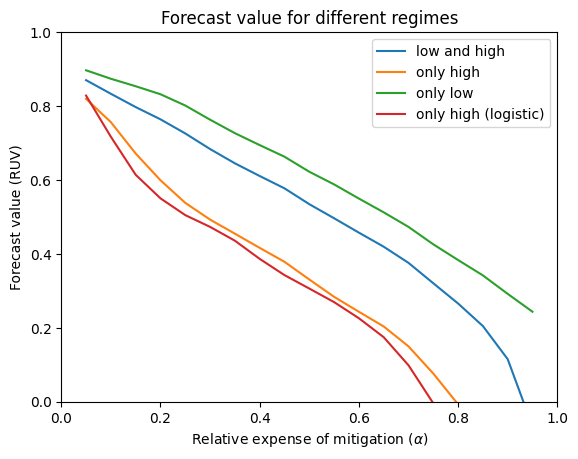

In [21]:
for name, damage_function in damage_functions.items():
    results[name].plot(label=name)
plt.title('Forecast value for different regimes')
plt.xlabel(r'Relative expense of mitigation ($\alpha$)')
plt.ylabel('Forecast value (RUV)')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()